#### This notebook was created to find the optimal $\Delta AF$ threshold for SNPs between paired samples using the *Replicate* Samples to approximate the noise in allele frequency calculations between samples.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy
from collections import Counter
from itertools import compress

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import warnings
warnings.filterwarnings("ignore", module="matplotlib")

In [3]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=2
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

### Import sample annotation for filtered Replicate & Longitudinal pairs

In [4]:
replicate_sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Replicate_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',')
longitudinal_sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',')

In [5]:
replicate_sample_annotation.head(n=2)

,patient_id,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
0,replicate_pair_18,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMYK00000000,Peru4938,0,Peru4938,replicate
1,replicate_pair_18,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R07...,CP_REP,NaN,01-R0774,0,01-R0774,replicate


In [6]:
longitudinal_sample_annotation.head(n=2)

,patient_id,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
0,P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
1,P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal


#### Import SNPs (with $\Delta AF > 25 \% $) for Replicate Sample and Longitudinal Sample Pairs

In [7]:
replicate_pair_SNPs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/replicate_SNPs/SNPs_between_isolates_delta_25.pkl')
longitudinal_pair_SNPs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_25.pkl')

In [8]:
replicate_pair_SNPs.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CP_REP,replicate_pair_68,1096600,A,G,Rv0980c_Rv0981,None,None,None,0.27,I,None
1,CP_REP,replicate_pair_68,2334234,C,A,Rv2077c,61,Non-Essential,NaN,0.72,N,G21C
2,CP_REP,replicate_pair_68,2372550,G,C,Rv2112c,20,Non-Essential,NaN,0.27,N,P7R
3,CP_REP,replicate_pair_68,3244804,T,G,Rv2930,1108,Non-Essential,fadD26,0.66,N,S370A
4,CP_REP,replicate_pair_68,3736179,G,A,Rv3343c,757,PE/PPE,PPE54,0.69,S,L253L


In [9]:
longitudinal_pair_SNPs.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.00,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.00,N,I156S
2,CASALI,P251,4402310,A,G,Rv3913,583,Essential,trxB2,0.48,N,I195V
3,CETR,2968,656329,A,C,Rv0565c,1142,Non-Essential,NaN,0.50,N,V381G
4,CETR,2968,656956,C,T,Rv0565c,515,Non-Essential,NaN,0.34,N,W172*


In [10]:
len( set(replicate_sample_annotation.patient_id) )

62

### Drop any glpK mutants that occur between any replicate pairs and longitudinal pairs

#### glpK mutants present in replicate pairs

In [11]:
np.shape(replicate_pair_SNPs)

(93, 12)

In [12]:
replicate_pair_SNPs[replicate_pair_SNPs.gene_symbol == 'glpK']

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
5,CP_REP,replicate_pair_68,4138398,G,A,Rv3696c,1358,Non-Essential,glpK,0.81,N,A453V
11,CP_REP,replicate_pair_11,4139083,G,A,Rv3696c,673,Non-Essential,glpK,0.38,N,R225W
17,CP_REP,replicate_pair_32,4138326,A,G,Rv3696c,1430,Non-Essential,glpK,0.47,N,L477P
21,TR_REP,P12_3,4138995,G,A,Rv3696c,761,Non-Essential,glpK,0.29,N,P254L
22,TR_REP,P12_2,4138995,G,A,Rv3696c,761,Non-Essential,glpK,0.29,N,P254L
86,CP_REP,replicate_pair_30,4139424,G,A,Rv3696c,332,Non-Essential,glpK,0.28,N,A111V


In [13]:
float( len(set(replicate_sample_annotation.patient_id)) )

62.0

#### There were 5 *glpK* mutants (the 2 mutants from the Trauner et. al. dataset count as one since there were 3 isolates compared pair-wise) that were found among 62 replicate pairs

Drop *glpK* mutants from the rest of the analysis

In [14]:
replicate_pair_SNPs = replicate_pair_SNPs[replicate_pair_SNPs.gene_symbol != 'glpK']

In [15]:
np.shape(replicate_pair_SNPs)

(87, 12)

#### glpK mutants present in longitudinal pairs

In [16]:
np.shape(longitudinal_pair_SNPs)

(1599, 12)

In [17]:
longitudinal_pair_SNPs[longitudinal_pair_SNPs.gene_symbol == 'glpK']

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
124,CETR,2321,4138645,G,A,Rv3696c,1111,Non-Essential,glpK,0.93,N,P371S
1148,CETR,2026,4138398,G,A,Rv3696c,1358,Non-Essential,glpK,0.79,N,A453V
1511,CETR,1972,4138599,C,A,Rv3696c,1157,Non-Essential,glpK,0.43,N,R386L
1512,CETR,1972,4138945,A,G,Rv3696c,811,Non-Essential,glpK,0.41,N,C271R


In [18]:
float( len(set(longitudinal_sample_annotation.patient_id)) )

200.0

#### There were 4 *glpK* mutants that were found among 200 longitudinal pairs

Drop *glpK* mutants from the rest of the analysis

In [19]:
longitudinal_pair_SNPs = longitudinal_pair_SNPs[longitudinal_pair_SNPs.gene_symbol != 'glpK']

In [20]:
np.shape(longitudinal_pair_SNPs)

(1595, 12)

### Split SNPs up into different types of replicate pairs

SNPs between CETR-POOLS replicate pairs

In [21]:
cetr_pools_replicates = replicate_pair_SNPs[replicate_pair_SNPs.population == 'CP_REP']

In [22]:
np.shape(cetr_pools_replicates)

(87, 12)

SNPs between Re-Sequenced (due to low coverage) replicate pairs

In [23]:
low_cov_reseq_replicates = replicate_pair_SNPs[replicate_pair_SNPs.population == 'LC_REP']

In [24]:
np.shape(low_cov_reseq_replicates)

(0, 12)

SNPs between Trauner Patient 12 sputum sample replicate pairs

In [25]:
trauner_P12_replicates = replicate_pair_SNPs[replicate_pair_SNPs.population == 'TR_REP']

In [26]:
np.shape(trauner_P12_replicates)

(0, 12)

### Replicate Sample Pairs

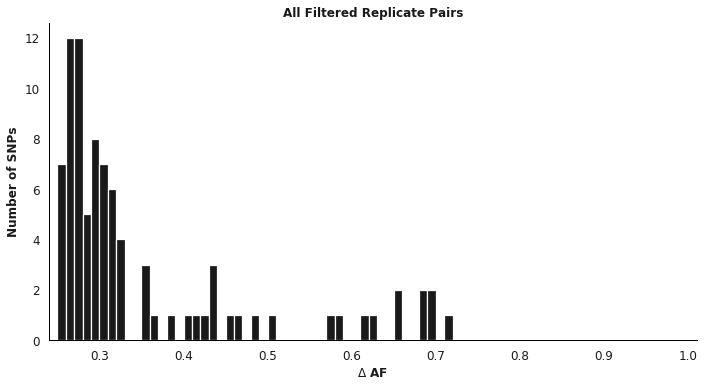

In [27]:
fig , ax = plt.subplots()

bins = np.arange( np.min(replicate_pair_SNPs.alt_AF_diff) , np.max(replicate_pair_SNPs.alt_AF_diff) + 0.01 , 0.01)
n , bins , patches = plt.hist(replicate_pair_SNPs.alt_AF_diff , bins = bins , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.25)

plt.title('All Filtered Replicate Pairs', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('$\Delta$ AF', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

ax.set_xlim(0.24 , 1.01)

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/replicate_vs_longitudinal_analysis/distribution_of_delta_AFs_for_all_replicate_SNPs.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Longitudinal Pairs

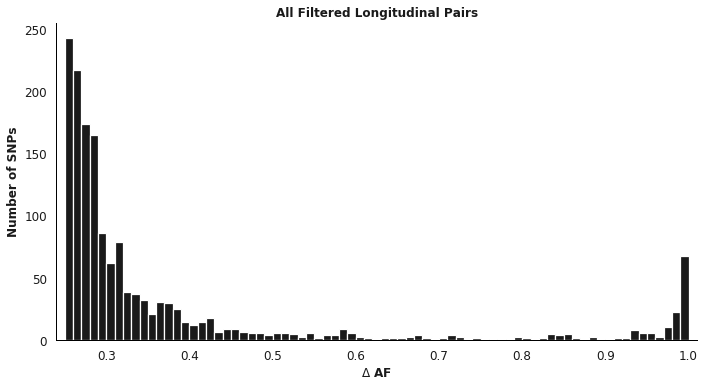

In [28]:
fig , ax = plt.subplots()

bins = np.arange( np.min(longitudinal_pair_SNPs.alt_AF_diff) , np.max(longitudinal_pair_SNPs.alt_AF_diff) + 0.01 , 0.01)
n , bins , patches = plt.hist(longitudinal_pair_SNPs.alt_AF_diff , bins = bins , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.25)

plt.title('All Filtered Longitudinal Pairs', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('$\Delta$ AF', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

ax.set_xlim(0.24 , 1.01)

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/replicate_vs_longitudinal_analysis/distribution_of_delta_AFs_for_all_longitudinal_SNPs.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Probe into the SNPs from the different types of replicates

Low Coverage Samples that were Re-Sequenced

In [29]:
print 'Number of Replicate Pairs = ' + str( len(set(low_cov_reseq_replicates.patient_id)) )

Number of Replicate Pairs = 0


In [30]:
pd.Series( Counter( list( replicate_pair_SNPs[replicate_pair_SNPs.population == 'LC_REP'].patient_id) ) ).sort_values(ascending = False)

Series([], dtype: float64)

#### CETR - POOLS replicate pairs

In [31]:
print 'Number of Replicate Pairs = ' + str( len(set(cetr_pools_replicates.patient_id)) )

Number of Replicate Pairs = 34


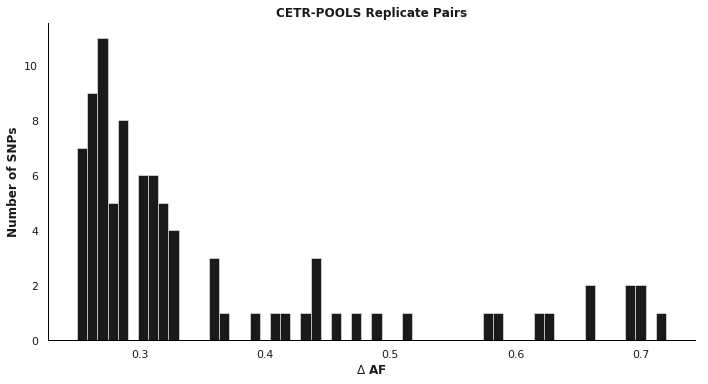

In [32]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(replicate_pair_SNPs[replicate_pair_SNPs.population == 'CP_REP'].alt_AF_diff , bins = 58 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.5)

plt.title('CETR-POOLS Replicate Pairs', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('$\Delta$ AF', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
#ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

plt.show()

In [33]:
pd.Series( Counter( list( replicate_pair_SNPs[replicate_pair_SNPs.population == 'CP_REP'].patient_id) ) ).sort_values(ascending = False).head(n=20)

replicate_pair_0     18
replicate_pair_27    12
replicate_pair_68     5
replicate_pair_11     4
replicate_pair_10     3
replicate_pair_12     3
replicate_pair_61     3
replicate_pair_59     3
replicate_pair_29     2
replicate_pair_13     2
replicate_pair_14     2
replicate_pair_16     2
replicate_pair_18     2
replicate_pair_2      2
replicate_pair_24     2
replicate_pair_4      2
replicate_pair_71     2
replicate_pair_50     2
replicate_pair_40     1
replicate_pair_15     1
dtype: int64

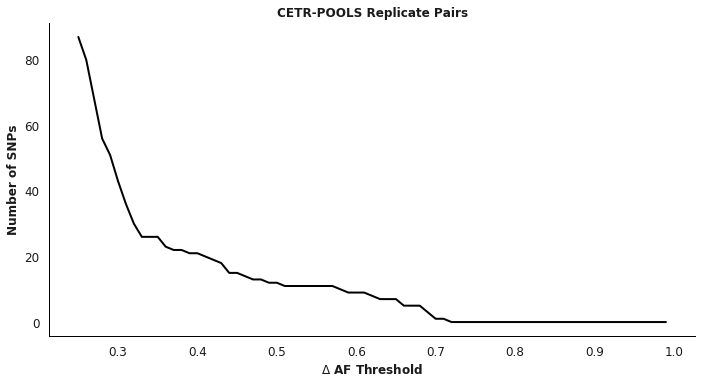

In [34]:
#Allele Frequence Changes for SNPs from low-coverage replicate pairs
SNP_AF_deltas = replicate_pair_SNPs[replicate_pair_SNPs.population == 'CP_REP'].alt_AF_diff.values

#create array of different Allele Frequency change thresholds
AF_delta_thresholds = np.arange(0.25 , 1.0 , 0.01)

#store the number of SNPs that pass the threshold
SNPs_passed_threshold = []

for delta_thershold in AF_delta_thresholds:
    
    SNPs_passed_threshold.append( float( sum(SNP_AF_deltas >= delta_thershold) ) )
    
#plot threshold vs. number of SNPs that pass threshold
fig , ax = plt.subplots()

plt.plot( AF_delta_thresholds , SNPs_passed_threshold , color = 'black' , linewidth=2.0 )

plt.title('CETR-POOLS Replicate Pairs', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('$\Delta$ AF Threshold', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

plt.show()

In [35]:
cetr_pools_replicates.sort_values(by='alt_AF_diff' , ascending = False).head(n=20)

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
1,CP_REP,replicate_pair_68,2334234,C,A,Rv2077c,61,Non-Essential,NaN,0.72,N,G21C
90,CP_REP,replicate_pair_24,2396877,A,G,Rv2136c_Rv2137c,None,None,None,0.70,I,None
14,CP_REP,replicate_pair_13,3820446,G,C,Rv3401_Rv3402c,None,None,None,0.70,I,None
15,CP_REP,replicate_pair_13,3820449,T,G,Rv3401_Rv3402c,None,None,None,0.69,I,None
4,CP_REP,replicate_pair_68,3736179,G,A,Rv3343c,757,PE/PPE,PPE54,0.69,S,L253L
13,CP_REP,replicate_pair_11,4316195,G,C,Rv3843c,402,Non-Essential,NaN,0.66,N,F134L
3,CP_REP,replicate_pair_68,3244804,T,G,Rv2930,1108,Non-Essential,fadD26,0.66,N,S370A
64,CP_REP,replicate_pair_12,3819146,C,A,Rv3401,1105,Non-Essential,NaN,0.63,N,P369T
56,CP_REP,replicate_pair_4,761004,A,G,Rv0667,1198,Antibiotic Resistance,rpoB,0.62,N,T400A
62,CP_REP,replicate_pair_12,292334,C,T,Rv0243,164,Non-Essential,fadA2,0.59,N,A55V


### Trauner Patient-12 replicate pairs

In [36]:
print 'Number of Replicate Pairs = ' + str( len(set(trauner_P12_replicates.patient_id)) )

Number of Replicate Pairs = 0


In [37]:
pd.Series( Counter( list( replicate_pair_SNPs[replicate_pair_SNPs.population == 'TRAUNER'].patient_id) ) ).sort_values(ascending = False)

Series([], dtype: float64)

## Compare Avg Number of SNPs per Replicate Pair and Longitudinal Pair

#### Allele Frequence Changes for SNPs from replicate pairs

In [38]:
SNP_AF_deltas = replicate_pair_SNPs.alt_AF_diff.values

#create array of different Allele Frequency change thresholds
AF_delta_thresholds = np.arange(0.25 , 1.00 , 0.01)
AF_delta_thresholds = [round(threshold,2) for threshold in AF_delta_thresholds]

#store the number of SNPs that pass the threshold
SNPs_passed_threshold = []

for delta_thershold in AF_delta_thresholds:
    
    SNPs_passed_threshold.append( float( sum(SNP_AF_deltas >= delta_thershold) ) )

num_replicate_pairs = float( len(set(replicate_sample_annotation.patient_id)) )
avg_SNPs_passed_threshold_replicate = np.array( SNPs_passed_threshold ) / num_replicate_pairs

#### Allele Frequence Changes for SNPs from longitudinal pairs

In [39]:
SNP_AF_deltas = longitudinal_pair_SNPs.alt_AF_diff.values

#create array of different Allele Frequency change thresholds
AF_delta_thresholds = np.arange(0.25 , 1.00 , 0.01)
AF_delta_thresholds = [round(threshold,2) for threshold in AF_delta_thresholds]

#store the number of SNPs that pass the threshold
SNPs_passed_threshold = []

for delta_thershold in AF_delta_thresholds:
    
    SNPs_passed_threshold.append( float( sum(SNP_AF_deltas >= delta_thershold) ) )

num_longitudinal_pairs = float( len(set(longitudinal_sample_annotation.patient_id)) )
avg_SNPs_passed_threshold_longitudinal = np.array( SNPs_passed_threshold ) / num_longitudinal_pairs

Set $\Delta AF$ threshold ($\Delta AF_T$) where SNPs from replicate pairs represent $\approx 5 \%$ of SNPs between pooled replicate and longitudinal isolate pairs, weighted by the number of pairs in each group, find $\Delta AF_T$ such that

$$\frac{ [(\text{Number of Replicate SNPs} \ge \Delta AF_T) / (\text{Number of Replicate Pairs})]}{[(\text{Number of Replicate SNPs} \ge \Delta AF_T) / (\text{Number of Replicate Pairs})] + [(\text{Number of Longitudinal SNPs} \ge \Delta AF_T) / (\text{Number of Longitudinal Pairs})]} = \frac{[\text{Avg Number of SNPs per Replicate Pair}]}{[\text{Avg Number of SNPs per Replicate Pair}] + [\text{Avg Number of SNPs per Longitudinal Pair}]} \approx 5\% $$

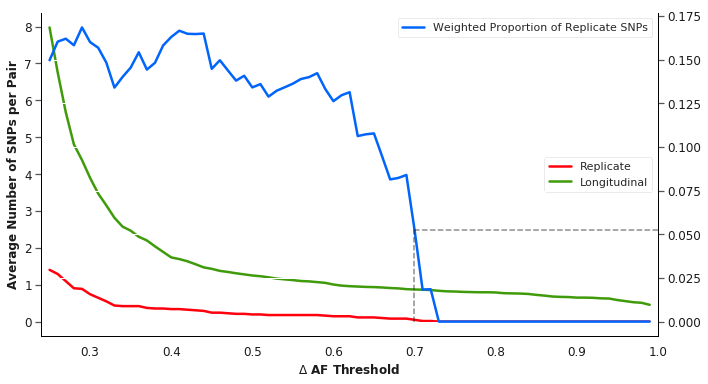

In [40]:
#plot threshold vs. number of SNPs that pass threshold
################################################################################################################################################
fig , ax1 = plt.subplots()

ax1.plot( AF_delta_thresholds , avg_SNPs_passed_threshold_replicate , color = 'xkcd:bright red' , linewidth=2.5 , label = 'Replicate')
ax1.plot( AF_delta_thresholds , avg_SNPs_passed_threshold_longitudinal , color = 'xkcd:grass green' , linewidth=2.5 , label = 'Longitudinal' )

ax1.set_xlabel('$\Delta$ AF Threshold', fontweight = 'bold' , fontsize = 12, color = 'k')
ax1.set_ylabel('Average Number of SNPs per Pair', fontweight = 'bold' , fontsize = 12, color = 'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.tick_params(labelcolor = 'k')
ax1.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
ax1.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')

ax1.set_xlim(0.24 , 1.0)
ax1.legend(loc='right')
################################################################################################################################################

#second super imposed plot, graph the ratio of average number of longitudinal SNPs / avg number of replicate SNPs
################################################################################################################################################
ax2 = ax1.twinx()

#for each threshold, divide the avg number of SNPs from replicate isolates OVER the avg number of SNPs from replicate isolates + the avg number of SNPs from longitudinal isolates
weighted_proportion_SNPs_from_replicates = avg_SNPs_passed_threshold_replicate / (avg_SNPs_passed_threshold_replicate + avg_SNPs_passed_threshold_longitudinal)
ax2.plot( AF_delta_thresholds , weighted_proportion_SNPs_from_replicates , color = 'xkcd:bright blue' , linewidth=2.5 , label = 'Weighted Proportion of Replicate SNPs')

#convert weighted proportion SNPs from replicates to percentages & round to the nearest whole number
weighted_percentage_replicate_SNPs_rounded = np.array( [int(np.round(float(x) , 0)) for x in 100*weighted_proportion_SNPs_from_replicates] )

#find the delta & proportion at which weighted proportion of replicate SNPs is about 5% of weighted SNPs from replicate + longitudinal pairs
delta_AF_threshold = list(compress(AF_delta_thresholds, list( weighted_percentage_replicate_SNPs_rounded <= 5 )))[0]
weighted_proportion_SNPs_from_replicates_at_threshold = list(compress(weighted_proportion_SNPs_from_replicates, list( weighted_percentage_replicate_SNPs_rounded <= 5 )))[0]

ax2.plot([delta_AF_threshold , delta_AF_threshold] , [0 , weighted_proportion_SNPs_from_replicates_at_threshold] , color = 'k' , linewidth = 1.5 , linestyle = '--' , alpha = 0.5)
ax2.plot([delta_AF_threshold , 1.0] , [weighted_proportion_SNPs_from_replicates_at_threshold , weighted_proportion_SNPs_from_replicates_at_threshold] , color = 'k' , linewidth = 1.5 , linestyle = '--', alpha = 0.5)


ax2.spines['top'].set_visible(False)
plt.rcParams["axes.grid"] = False

ax2.tick_params(labelcolor = 'k')
ax2.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
ax2.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')

ax2.legend(loc='upper right')
################################################################################################################################################

fig = plt.gcf()
fig.set_size_inches(10.0, 5.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/replicate_vs_longitudinal_analysis/avg_num_SNPs_vs_delta_AF_threshold.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

In [41]:
print delta_AF_threshold

0.7


In [42]:
print weighted_proportion_SNPs_from_replicates_at_threshold #there are over 20x as many avg SNPs per longitudinal pair than there are avg SNPs per replicate pair

0.05268703898840885


Number of Replicate Pairs

In [43]:
num_replicate_pairs = float( len(set(replicate_sample_annotation.patient_id)) )
print num_replicate_pairs

62.0


Number of SNPs between Replicate Pairs with $\Delta AF \ge 70\%$  

In [44]:
num_replicate_SNPs_above_threshold = sum( replicate_pair_SNPs.alt_AF_diff.values >= 0.70 )
print num_replicate_SNPs_above_threshold

3


Number of Longitudinal Pairs

In [45]:
num_longitudinal_pairs = float( len(set(longitudinal_sample_annotation.patient_id)) )
print num_longitudinal_pairs

200.0


Number of SNPs between Longitudinal Pairs with $\Delta AF \ge 70\%$  

In [46]:
num_longitudinal_SNPs_above_threshold = sum( longitudinal_pair_SNPs.alt_AF_diff.values >= 0.70 )
print num_longitudinal_SNPs_above_threshold

174


Sanity check that this $\Delta AF \ge 70\%$ results in $\approx 5\%$ SNPs from Replicate Pairs 

In [47]:
( (float(num_replicate_SNPs_above_threshold) / num_replicate_pairs) /  ( (float(num_replicate_SNPs_above_threshold) / num_replicate_pairs) + (float(num_longitudinal_SNPs_above_threshold) / num_longitudinal_pairs) ) ) * 100

5.268703898840886

Take a look at some of the longitudinal SNPs passing this threshold

In [48]:
longitudinal_pair_SNPs[longitudinal_pair_SNPs.alt_AF_diff >= 0.70].sort_values(by = 'alt_AF_diff').head(n=20)

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
852,WALKER,P000226,2154695,C,A,Rv1908c,1417,Antibiotic Resistance,katG,0.70,N,V473F
850,WALKER,P000226,1247263,G,T,Rv1124,137,Non-Essential,ephC,0.71,N,C46F
1080,CETR,3451,9582,A,G,Rv0006,2281,Antibiotic Resistance,gyrA,0.71,N,R761G
1138,WITNEY,16,4326401,C,G,Rv3854c,1073,Antibiotic Resistance,ethA,0.72,N,G358A
1432,GUERRA,KPS_17,3220190,G,A,Rv2913c,1509,Non-Essential,NaN,0.72,S,R503R
1082,CETR,3451,2288697,A,C,Rv2043c,545,Antibiotic Resistance,pncA,0.72,N,L182W
938,GUERRA,KPS_24,851701,A,G,Rv0757,94,Non-Essential,phoP,0.72,N,I32V
820,TRAUNER,P11,1767490,G,C,Rv1563c,1943,Non-Essential,treY,0.73,N,T648S
1081,CETR,3451,2062292,G,T,Rv1818c,383,PE/PPE,PE_PGRS33,0.73,N,T128N
1084,CETR,3451,3301183,C,A,Rv2950c,1273,Non-Essential,fadD29,0.73,N,V425F
